## FINTA Analysis Dashboard

### Setup

In [3]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from database import Lecture, get_lecture
import pandas as pd
from IPython.display import display, clear_output

sns.set_style("whitegrid")

def generate_dataframe(vorlesung: Lecture, start_date=None, end_date=None):
    rows = []
    for entry in get_lecture(vorlesung):
        rows.append({
            "Vorlesung": entry.number,
            "Datum": entry.date,
            "Gesamt": entry.total,
            "FINTA": entry.finta,
            "Prozent": entry.quota
        })
    df = pd.DataFrame(rows)
    df.sort_values(["Datum", "Vorlesung"], inplace=True)
    df["Datum"] = pd.to_datetime(df["Datum"])
    if start_date:
        df = df[df["Datum"] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df["Datum"] <= pd.to_datetime(end_date)]
    return df

### Control Panel

In [4]:
vorlesung_selector = widgets.Dropdown(options=[(v.name, v) for v in Lecture], description="Vorlesung:")

def update_dates(change):
    df = generate_dataframe(vorlesung_selector.value)
    if not df.empty:
        min_date = df['Datum'].min().date()
        max_date = df['Datum'].max().date()
        start_date.value = min_date
        end_date.value = max_date

start_date = widgets.DatePicker(description='Start Date:', disabled=False)
end_date = widgets.DatePicker(description='End Date:', disabled=False)

vorlesung_selector.observe(update_dates, names='value')
update_dates(None)

analyze_button = widgets.Button(description="Analyze", button_style='primary')
output = widgets.Output()

def analyze(b):
    with output:
        clear_output(wait=True)
        df = generate_dataframe(vorlesung_selector.value, start_date.value, end_date.value)
        
        if df.empty:
            print("No data available for selected range")
            return
        
        # Data Table
        print("=" * 80)
        print(f"DATA TABLE - {vorlesung_selector.value.value}")
        print("=" * 80)
        df_display = df.copy()
        df_display['Datum'] = df_display['Datum'].dt.strftime('%d.%m.%Y')
        df_display['Prozent'] = df_display['Prozent'].apply(lambda x: f"{x} %")
        print(df_display.to_string(index=False))
        print("\n")
        
        # Summary Statistics
        print("=" * 80)
        print("SUMMARY STATISTICS")
        print("=" * 80)
        print(f"Total Lectures: {len(df)}")
        print(f"Average FINTA %: {df['Prozent'].mean():.2f}%")
        print(f"Min FINTA %: {df['Prozent'].min():.2f}%")
        print(f"Max FINTA %: {df['Prozent'].max():.2f}%")
        print(f"Std Dev: {df['Prozent'].std():.2f}%")
        print(f"Median: {df['Prozent'].median():.2f}%")
        print("\n")
        
        # Trend Line
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        axes[0, 0].plot(df['Datum'], df['Prozent'], marker='o', linewidth=2)
        axes[0, 0].set_xlabel('Datum')
        axes[0, 0].set_ylabel('FINTA %')
        axes[0, 0].set_title('FINTA Percentage Trend')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Stacked Bar
        df['Non-FINTA'] = df['Gesamt'] - df['FINTA']
        axes[0, 1].bar(df['Datum'].dt.strftime('%d.%m'), df['FINTA'], label='FINTA')
        axes[0, 1].bar(df['Datum'].dt.strftime('%d.%m'), df['Non-FINTA'], bottom=df['FINTA'], label='Non-FINTA')
        axes[0, 1].set_xlabel('Datum')
        axes[0, 1].set_ylabel('Anzahl')
        axes[0, 1].set_title('Attendance Breakdown')
        axes[0, 1].legend()
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Distribution
        axes[1, 0].hist(df['Prozent'], bins=10, edgecolor='black')
        axes[1, 0].set_xlabel('FINTA %')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Distribution')
        
        # Rolling Average
        df['Rolling_Avg'] = df['Prozent'].rolling(window=3, min_periods=1).mean()
        axes[1, 1].plot(df['Datum'], df['Prozent'], marker='o', alpha=0.5, label='Actual')
        axes[1, 1].plot(df['Datum'], df['Rolling_Avg'], marker='s', linewidth=2, label='3-Lecture Avg')
        axes[1, 1].set_xlabel('Datum')
        axes[1, 1].set_ylabel('FINTA %')
        axes[1, 1].set_title('Rolling Average')
        axes[1, 1].legend()
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Additional Charts
        fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5))
        
        # Volatility
        mean = df['Prozent'].mean()
        std = df['Prozent'].std()
        axes2[0].plot(df['Datum'], df['Prozent'], marker='o', label='FINTA %')
        axes2[0].axhline(mean, color='red', linestyle='--', label=f'Mean: {mean:.1f}%')
        axes2[0].fill_between(df['Datum'], mean-std, mean+std, alpha=0.2, label=f'±1 SD: {std:.1f}%')
        axes2[0].set_xlabel('Datum')
        axes2[0].set_ylabel('FINTA %')
        axes2[0].set_title('Volatility Analysis')
        axes2[0].legend()
        axes2[0].tick_params(axis='x', rotation=45)
        
        # Correlation
        axes2[1].scatter(df['Gesamt'], df['Prozent'], s=100, alpha=0.6)
        z = np.polyfit(df['Gesamt'], df['Prozent'], 1)
        p = np.poly1d(z)
        axes2[1].plot(df['Gesamt'], p(df['Gesamt']), 'r--', alpha=0.8)
        corr = df['Gesamt'].corr(df['Prozent'])
        axes2[1].set_xlabel('Total Attendance')
        axes2[1].set_ylabel('FINTA %')
        axes2[1].set_title(f'Correlation Analysis (r={corr:.3f})')
        
        plt.tight_layout()
        plt.show()

analyze_button.on_click(analyze)

display(widgets.VBox([vorlesung_selector, start_date, end_date, analyze_button, output]))

### Cross-Course Comparison

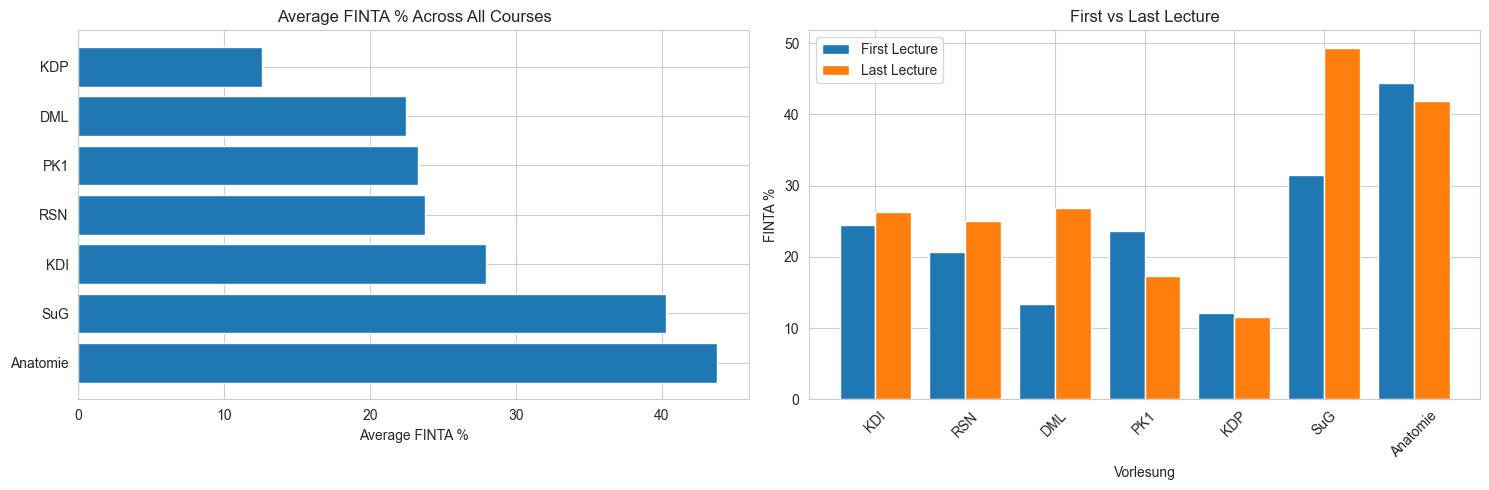

In [28]:
def plot_all_courses():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Average comparison
    averages = []
    for v in Lecture:
        df = generate_dataframe(v)
        if not df.empty:
            averages.append({'Vorlesung': v.name, 'Avg': df['Prozent'].mean()})
    comp_df = pd.DataFrame(averages).sort_values('Avg', ascending=False)
    axes[0].barh(comp_df['Vorlesung'], comp_df['Avg'])
    axes[0].set_xlabel('Average FINTA %')
    axes[0].set_title('Average FINTA % Across All Courses')
    
    # First vs Last
    data = []
    for v in Vorlesung:
        df = generate_dataframe(v)
        if len(df) >= 2:
            data.append({'Vorlesung': v.name, 'First': df.iloc[0]['Prozent'], 'Last': df.iloc[-1]['Prozent']})
    comp_df2 = pd.DataFrame(data)
    x = np.arange(len(comp_df2))
    axes[1].bar(x - 0.2, comp_df2['First'], 0.4, label='First Lecture')
    axes[1].bar(x + 0.2, comp_df2['Last'], 0.4, label='Last Lecture')
    axes[1].set_xlabel('Vorlesung')
    axes[1].set_ylabel('FINTA %')
    axes[1].set_title('First vs Last Lecture')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(comp_df2['Vorlesung'], rotation=45)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_all_courses()